Module 3, Lab 3 - Causal Claims
===============================

In this lab, we briefly explore the causal claim. Recall that if you
want to truly understand your variables, you want to draw cause-effect
conclusions. 

In this lab, we will use the `effsize` package for measuring effect size
and the `ggplot2` package for data visualization. We will also briefly
explore the `ggridges` package.

In [1]:
#### LOAD PACKAGES ####
from scipy import stats
import scipy.stats as ss
import pandas as pd
import numpy as np
import statsmodels.stats.weightstats as ws
from statsmodels.stats.power import tt_ind_solve_power
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Weaknesses of Association Claims for Deep Understanding
========================================================

Association claims are useful; they let you know what variables correlate
with each other. However, they don't tell you what will happen if you
intervene and act in the world in new ways. For example, imagine you have
been analyzing data at your organization and find that employees who are
less stressed tend to be more productive. It may be very unclear *why* that
relationship exists. Some possibilities include:

1.  Stress reduces productivity
2.  Productivity reduces stress
3.  Some other variable is causing both of them

It is worth putting real thought into all of these.

1.  For example, it is reasonable that stress reduces productivity.
2.  However, it is also reasonable that getting things done may take
    stress off of the shoulders of employees as they clear projects off
    their to-do lists.
3.  It is also possible that something else may be casing both high
    stress and low productivity, such as obligations outside of work,
    health issues, etc.

All three of these have different implications for how to increase
productivity:

1.  The first possibility suggests that reducing stress might actually
    help.
2.  The second possibility suggests that reducing stress will not help
    (but finding other contributors to productivity might, so we should
    go looking for those). Time for more research!
3.  The third possibility suggests that attempts to reduce stress would
    do nothing to increase productivity because the real problem is the
    unmeasured *prior cause* of the stress. For example, if health
    issues are causing people to be more stressed and less productive,
    then the desired boost to productivity will not come from reducing
    stress but from fixing the underlying health issues.

In conclusion, association claims are limited in their ability to help
you draw cause-effect conclusions. Or, to put it differently, we could
*predict* the productivity of an employee given their stress levels, but
we wouldn't know how to actually *improve* productivity given this
information. Association claims simply don't really tell you what is
causing what.

Solution: The Experiment
========================

To solve this problem, we run an experiment. Imagine we randomly assign
250 employees to either a stress-reduction treatment or a "business-as-usual"
control group. After 7 weeks, the productivity of these employees is
assessed.

Because employees are *randomly* assigned to groups *by the researcher*,
the research can be confident that

-   The two groups were approximately equal to begin with (this can be
    checked, if desired)
-   Any differences at the end of the study are due to the treatment

We can draw this conclusion because we will be very careful to treat the
groups *identically* in every way, except for the treatment. We must be
**exceedingly** careful on this point, as any unintended differences in
treatment (the messaging we give them, the scheduling, workload, etc.)
could accidentally cause a second systematic difference between our
groups, and then we would not be sure what was really responsible for
any effects we end up seeing. This is known as a *confound* and it would
run our experiment. We will be very sure not to allow this to happen,
using strict protocols, scripts, email templates, etc. We would be very
careful to manage expectations so neither group had different
expectations (possibly keeping our employees blind to some of the
details, or keeping managers in the dark). Our goal will be to keep
**everything the same between our groups**, tangibly and mentally,
except for the actual treatment itself. This will take very detailed and
rigorous planning, but it is worth it. A small-scale pilot of an
intervention program will take some rigorous planning, but it is much
less expensive than rolling out a company-wide stress program only to
find it is a waste of money and ineffective (as might happen in many
organizations).

Analyzing the Experiment
========================

To analyze the experiment, a simple independent-groups *t*-test can be
performed. This compares the means of the two groups to determine if
they are statistically significantly different.

Imagine the study is done; the data are called "causal.csv" and are in
the github folder for this lab.

In [2]:
#### LOAD DATA ####
import pandas as pd
dat = pd.read_csv("datasets/causal.csv")

# Inspect data
print(dat.columns)

print('\n')
print(dat.head())

print('\n')
print(dat.group.unique())

dat.describe()

Index(['Unnamed: 0', 'group', 'prod'], dtype='object')


   Unnamed: 0         group  prod
0         261       control  3.44
1         168  intervention  3.26
2         498       control  4.26
3         447       control  4.53
4          64  intervention  5.92


['control' 'intervention']


,Unnamed: 0,prod
count,500.000000,500.000000
mean,250.500000,4.160080
std,144.481833,1.006379
min,1.000000,0.700000
25%,125.750000,3.522500
50%,250.500000,4.120000
75%,375.250000,4.817500
max,500.000000,7.850000


We see we have three variables, an unnamed id variable, a variable
listing the group, and the productivity scores of the employees on a 1-7
scale. We want to compare the two groups, and we can do so by looking at
the means.

We can quickly request more detailed statistics. The values of `prod` can be grouped by the `group` using the Pandas `groupby` method. The mean of each group is then computed. The same recipe can be used to compute the standard deviation of the groups. 

In [3]:
dat[['group','prod']].groupby('group').mean()

,prod
group,
control,4.01912
intervention,4.30104


In [4]:
dat[['group','prod']].groupby('group').std()

,prod
group,
control,0.985053
intervention,1.009671


We see here that intervention group has a slightly higher average
productivity score. We can next test the null hypothesis to see if this
difference is significant.

Recall that the null hypothesis always says that the **effect is absent
in the population** and that the sample result is an artifact of random
chance. In symbols, this means that the difference between the group
averages is exactly zero in the population.

*H*<sub>0</sub> : *μ*<sub>*g**r**o**u**p*1</sub> − *μ*<sub>*g**r**o**u**p*2</sub> = 0
 Remember that *μ* refers to the population average, so this is saying
that the population difference is exactly zero. Any difference observed
in our sample is therefore due to random chance. We run our *t*-test to
consider this possibility.

Recall that a *t*-test compares the size of the *observed difference*
($\bar{x}_{1} - \bar{x}_{2}$) against the value in the null hypothesis
(zero), divided by what is typically expected by chance:

$$t= \frac{result - null }{chance}$$
 For the two-group *t*-test, the "result" is the difference between the
group averages in the sample, the "null" states the difference, and
"chance" is the standard error of that difference.

How can we run our test? The default in R is to run the "Welch" version
of the test. This version of the test does *not* make any assumptions
about the variances of the two groups.

$$t'= \frac{result - null }{chance}= \frac{(\bar{x}_{1}-\bar{x}_{2}) - 0 }{\sqrt{\frac{\hat{\sigma}_1^2}{n_{1}}+\frac{\hat{\sigma}_2^2}{n_{2}}}}$$
 The bottom looks complicated but is simply a measure of the standard
error of the size of the difference between our two groups. We can
explore the details of this equation in a later lab. For now, let's run
the test and interpret the result.

The Python code in the function below does the following:
1. Compute the difference of means. 
2. The `ttest_ind` function from the scipy.stats package to compute the t statistic and p-value.
3. The `tconfint_diff` function is used to compute the confidence interval.
4. The `dof_satt` function estimates the degrees of freedom. 

In [5]:
def t_test_two_samp(df, alpha, alternative='two-sided'):
    
    a = df[df.group == 'control']['prod']
    b = df[df.group == 'intervention']['prod']    
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

test = t_test_two_samp(dat, 0.05)
test

DegFreedom    497.696852
Difference     -0.281920
Statistic      -3.160058
PValue          0.001673
Low95CI        -0.457202
High95CI       -0.106638
dtype: float64

The *t*-value of 3.16 tells us that the difference between our groups
(top of *t*-test fraction) is 3.16 times larger than would be expected
typically by chance (bottom of *t*-test fraction). How often would a
result this big happen if the null were actually true? The *p*-value is
.002, so only 0.2% of the time. This is sufficient to reject the null
(*p* &lt; .05), and we can conclude that our difference is not due to
chance. We also have a 95% CI on the size of the difference, and we are
fairly confident that the control group is .457 to 0.107 productivity
points lower than intervention group.

Importantly, because we performed a randomized, controlled experiment,
we can conclude that this was actually the result of our treatment. This
is a good sign, but the size of the improvement is small. We can
conclude that our intervention **did** improve productivity, but it was
only by about a quarter of a point.

How big is that? Well, the scale is a 1-7 scale. We can try plotting the data using a boxplot of the two groups to visualize it. The Seaborn code in the cell below creates a boxplot of the `prod` values grouped by the `group` variable. A `swarmplot` is superimposed so you can see the position of the data points. The swarm plot shows a jittered display of the data points.    

C:\Users\Raheem Nasiru\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


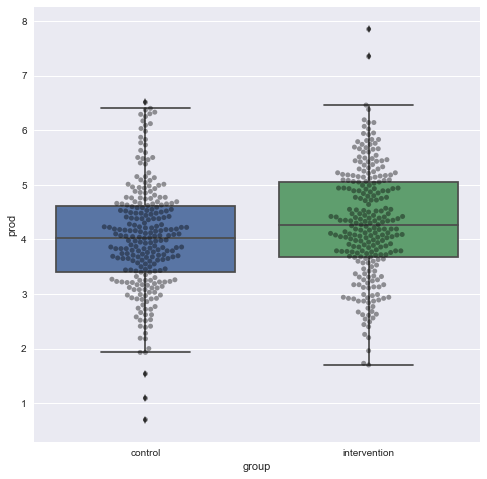

In [6]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'group', y = 'prod', data = dat, ax = ax)
sns.swarmplot(x = 'group', y = 'prod', color = 'black', data = dat, ax = ax, alpha = 0.4)

![](M3_Lab3_-_Causal_Claim_files/figure-markdown_strict/unnamed-chunk-5-1.png)

A violin plot might also help to visualize the differences. The code in the cell below follows the same recipe used above, but with the `violinplot` function. 

C:\Users\Raheem Nasiru\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Raheem Nasiru\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


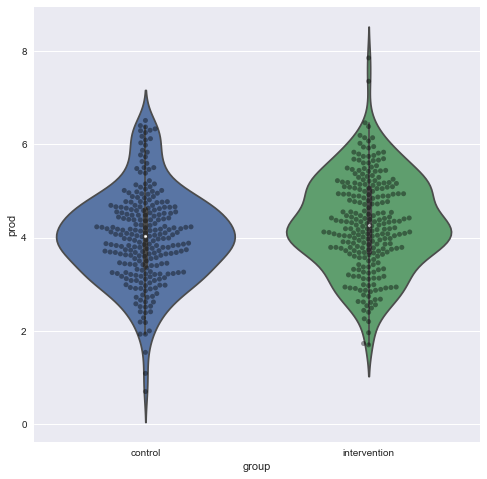

In [7]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.violinplot(x = 'group', y = 'prod', data = dat, ax = ax)
sns.swarmplot(x = 'group', y = 'prod', color = 'black', data = dat, ax = ax, alpha = 0.4)

![](M3_Lab3_-_Causal_Claim_files/figure-markdown_strict/unnamed-chunk-7-1.png)

We see from the above plots that, although the effect was statistically significant, the
difference is fairly minimal.

We can estimate our effect size (Cohen's *d*) using the `tt_ind_solve_power`
function from the `statsmodels.stats.power` package:

In [8]:
#cohen.d(prod ~ group, data=dat)
control = dat[dat.group == 'control']['prod']
intervention = dat[dat.group == 'intervention']['prod']
print(np.mean(intervention) - np.mean(control))
ratio = len(control)/len(intervention)
tt_ind_solve_power(effect_size=None, nobs1 = len(control), alpha=0.05, power=0.8, ratio=ratio, alternative='two-sided')

0.28191999999999773


0.25106561321145227

From these results you can see that the actual difference between these groups is a bit larger than Cohen's d required from 0.80 power.

Conclusion
==========

Thanks to this study, we can be fairly certain that the stress reduction
intervention had an effect. However, the difference in the effect is
minimal at best.